In this notebook we present how we computed a level 7 model that uses a custom binary crossentropy loss and predicted outputs from the test images by using rotations

In [ ]:
from google.colab import drive
import os
import re
import numpy as np
from skimage import io
import cv2
from tqdm.notebook import tqdm
from imgaug import augmenters as iaa

drive.mount("/content/gdrive", force_remount=True)

drive_path = "/content/gdrive/MyDrive/Project-KLM/" 
os.chdir(drive_path)

Mounted at /content/gdrive


In [ ]:
from libs.models import *
from libs.ImageGen import *
from libs.sliding_window import *
from libs.post_process import *
from libs.threshold import *
from libs.submission import *
from libs.augmentation import *

In [ ]:
#Parameters to load the data
input_dir = "training/images"
target_dir = "training/groundtruth/"
img_size = (400, 400) #Don't edit size
batch_size = 100
seed = 10

#Don't apply any data augmentation here, we just load the pictures in RAM
grayscale_x = False
crop_length = None 
aug_gen_args = {'validation_split' : 0.2}  #Only param is validation 80/20 split

#Load the data (80 training images, 20 validation images)
imgen = ImageGenerator(input_dir, target_dir, aug_gen_args, seed, img_size, batch_size, grayscale_x, force_batch_size=False)
train_gen, valid_gen = imgen.get_normal_generator()
train_x, train_y = next(train_gen)
valid_x, valid_y = next(valid_gen)

Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


# Augmenting validations set

In [ ]:
# set seed for reprodubility and retrieve (new) data to serve as validation
np.random.seed(seed)
new_x, new_y = apply_augments(valid_x), apply_augments(valid_y)

# validation set on pred_n = 96 images out of the 240 which result from the flips and rotations
pred_n = 96
selected_indices = np.random.randint(0,len(new_x),pred_n)
new_x, new_y = new_x[selected_indices], new_y[selected_indices]

cropper = iaa.Sequential([iaa.size.CropToFixedSize(width=256,height=256,random_state=1)])
cropped_x = cropper.augment_images(new_x)

cropper = iaa.Sequential([iaa.size.CropToFixedSize(width=256,height=256,random_state=1)])
cropped_y = cropper.augment_images(new_y)

# create batches from selected validation set
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

batched_x = [np.stack(x) for x in chunks(cropped_x,16)]
batched_y = [np.stack(y) for y in chunks(cropped_y,16)]

valid_cropped = (batched_x,batched_y)

print("Validation batches are of shape:")
batched_x[0].shape, batched_y[0].shape

Validation batches are of shape:


((16, 256, 256, 3), (16, 256, 256, 1))

# Data Augmentation Parameters

In [ ]:
aug_gen_args = {
    'rotation_range' : 90,
    'width_shift_range' : 0.2,
    'height_shift_range' : 0.2,
    'horizontal_flip' : False,
    'vertical_flip' : False,
}

## Binary Cross Entropy Loss

In [ ]:
#@title Definition of closure for Weighted Binary Cross Entropy
def create_weighted_binary_cross_entropy(zero_weight, one_weight):
  def weighted_binary_crossentropy(y_true, y_pred):
          # Calculate the binary crossentropy
          b_ce = K.binary_crossentropy(y_true, y_pred)

          # Apply the weights
          weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
          weighted_b_ce = weight_vector * b_ce

          # Return the mean error
          return K.mean(weighted_b_ce)

  return weighted_binary_crossentropy

In [ ]:
loss = create_weighted_binary_cross_entropy(0.45,0.55)

# Model computation

## Training of a Level 7 model

In [ ]:
from multiprocessing import Process,Value
from IPython.display import clear_output
from tensorflow.keras.metrics import Recall, Precision
from keras import backend as K
import sys

EPOCHS = 30
STEPS_PER_EPOCH = 250

def evaluate_model(i,stdout) :
  sys.stdout = stdout
  #We use a different seed for each model
  seed = random.randint(0,2**32 -1 )
  datagen = ImageDataGenerator(**aug_gen_args)
  train_image_gen = datagen.flow(train_x,seed=seed,batch_size=16)
  train_mask_gen  = datagen.flow(train_y,seed=seed,batch_size=16)
  train_gen = zip(train_image_gen, train_mask_gen)
  train_gen = crop_generator(train_gen, 256,seed)
  
  print('Creating model')
  callbacks = []
  callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3,patience=5, restore_best_weights=True))

  model = unet(post_processing=False, levels=7,metrics=[Recall(), Precision()])
  model.fit(train_gen, epochs=EPOCHS,loss=loss, validation_data=valid_cropped, steps_per_epoch=STEPS_PER_EPOCH,callbacks = callbacks)
  print('Saving ...')
  model.save(f'./models/Level7/level7_weighted.h5')


  return;

##Uncomment if you want to create new models

#p = Process(target=evaluate_model, args=(i,sys.stdout))
#p.start()
#p.join()
#K.clear_session()

## Loading already computed model

In [ ]:
model = keras.models.load_model(f'./models/Level7/level7_weighted.h5',custom_objects = {'weighted_binary_crossentropy': loss})

## Find best threshold on train set

In [ ]:
THRESHOLDS = [(x,create_vanilla_threshold(x)) for x in np.linspace(0.1*255,0.7*255,num=20)]
train_predictions = [predict_from_image_rotated(model, x, stride=72, rotations=[0,90,180,270], pad=False) for x in tqdm(train_x,leave=False)]
best_func, best_thresh, best_score = select_best_threshold(THRESHOLDS, train_predictions, train_y)
best_thresh, best_score

(122.13157894736841, 0.9386102989923034)

## Validation results

In [ ]:
valid_predictions = [predict_from_image_rotated(model, x, stride=72, rotations=[0,90,180,270], pad=False) for x in tqdm(new_x,leave=False)]
compute_score_thresholded(best_func, valid_predictions, new_y)

0.8924624324554655

# Loading test data and predicting

In [ ]:
from libs.submission import *

test_dir = "./test_set_images/"

#Load test images
test_imgs = load_test_images(test_dir)
predictions = [predict_from_image_rotated(model, x, stride=32, rotations=[0,90,180,270], pad=False) for x in tqdm(test_imgs,leave=False)]

Found 50 images belonging to 50 classes.


## Postprocess

In [ ]:
thresholded = [(best_func(x)).astype(int)*255 for x in tqdm(predictions,leave=False)]

## Create submission

In [ ]:
#Save images in folder
!mkdir level7-weighted
save_predictions_to_folder("./test_predictions/level7-weighted/", thresholded)

In [ ]:
#Use images saved in folder to create submission
create_submission("./test_predictions/level7-weighted/", "submissions/level7_weighted_55_submission.csv")

## Visualize submission

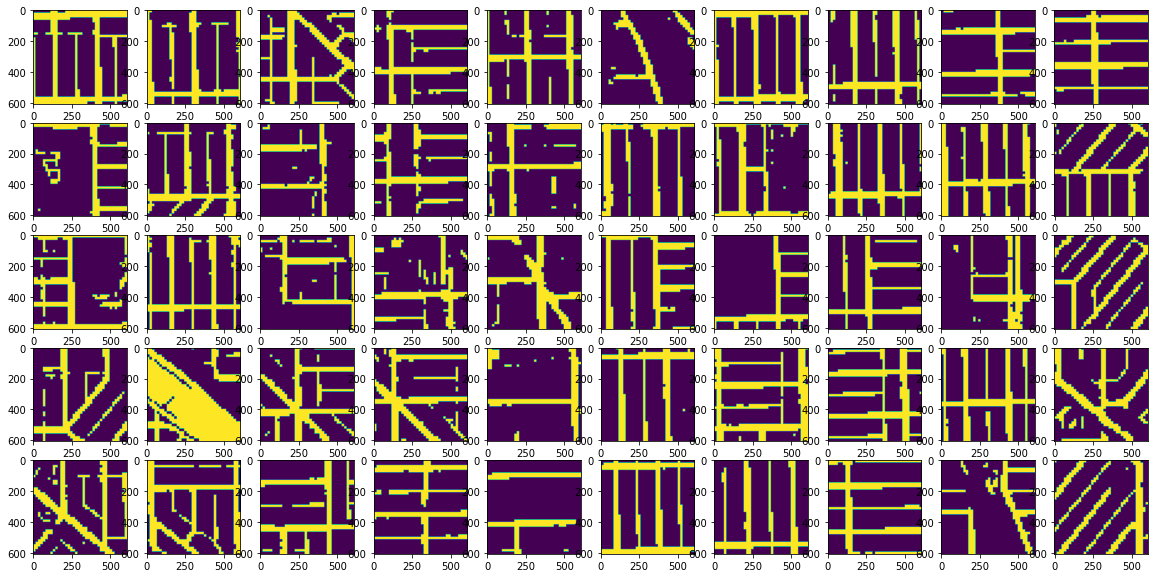

In [ ]:
plot_submission('submissions/level7_weighted_55_submission.csv')